# Backtesting Engine - Finalized Code

## Data Collection

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
data = pd.read_csv('VOL.IDXUSD_Ticks_24.03.2025-24.03.2025.csv')

data = data.drop_duplicates()

data = data.dropna()

data["Local time"] = pd.to_datetime(data["Local time"]) #convert the local time to a proper timestamp format

data = data.dropna(subset=['Ask','Bid']) #drop rows with missing ask or bid

data.to_parquet('cleaned_data.parquet')

C:\Users\anura\AppData\Local\Temp\ipykernel_18372\2073716473.py:7: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S.%f GMT%z format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["Local time"] = pd.to_datetime(data["Local time"]) #convert the local time to a proper timestamp format


In [13]:
#loading parquet file
try:
    data = pd.read_parquet("cleaned_data.parquet")
except FileNotFoundError:
    st.warning("Please upload the dataset or place 'cleaned_data.parquet' in the working directory.")

data = data.set_index('Local time') #setting local time as index for fast queries
data.sort_index(inplace=True) #sorting just in case

## Basic Strategy Implementation

In [14]:
#parameters
rollingWindow = 10
initial_capital = 10000

#portfolio initialisation
cash = initial_capital
position = 0 #how many units currently own(0)
position_price = 0 #price at which last position was bought
trade_log = [] #record of each buy/sell trade
portfolio_log = []

#rolling parameters
data['Mean'] = (data['Ask'] + data['Bid'])/2
    #Bid Price = The highest price someone is willing to pay to buy an asset
    #Ask Price = The lowest price someone is willing to sell the asset for

data['Rolling Avg'] = data['Mean'].rolling(window=rollingWindow).mean()

data['Rolling STD'] = data['Mean'].rolling(window=rollingWindow).std()
data['Upper Band'] = data['Rolling Avg'] + 2 * data['Rolling STD']
data['Lower Band'] = data['Rolling Avg'] - 2 * data['Rolling STD']

## Strategy Expansion

In [15]:
rsi_window = 10

def rsi(rsi_window, data):
    delta = data['Mean'].diff()
    #diff() - calculates how much the price changes compared to the previous value. ex:- [100,102,101] => [NaN,2,-1]
    gain = delta.clip(lower=0)
    #keep only the positive changes (gains) and set others to 0. ex:- gain:[NaN,2,0]
    loss = -delta.clip(upper=0)
    #keep only the negative changes (losses), but make them positive for math. ex:- loss:[NaN,0,1]

    avg_gain = gain.rolling(window=rsi_window).mean()
    avg_loss = loss.rolling(window=rsi_window).mean()

    rs = avg_gain/avg_loss

    rsi = 100 - (100/(1+rs))
    return rsi

data['RSI'] = rsi(rsi_window, data)

In [16]:
#strategy logic with RSI and SL/TP - actual backtesting strategy
stopLoss_percent = 0.02
takeProfit_percent = 0.03
rsi_oversold_limit = 40
rsi_overbought_limit = 65

def bollinger_rsi_strategy(stopLoss_percent, takeProfit_percent, rsi_oversold_limit, rsi_overbought_limit, data):

    global position, cash, position_price, trade_log, portfolio_log #so that python do not treat them as local variables

    portfolio_log.clear()
    trade_log.clear()
    portfolio_log.append({'Time': data.index[0], 'Portfolio': initial_capital})

    for time, row in data.iterrows():
        current_price = row['Mean']
        upper_band = row['Upper Band']
        lower_band = row['Lower Band']
        rsi = row['RSI']
        rolling_avg = row['Rolling Avg']

        if np.isnan(rolling_avg) or np.isnan(rsi):
            continue

    #entry conditions
        if position == 0:
            if current_price < lower_band and rsi < rsi_oversold_limit:
                position = cash / current_price
                position_price = current_price
                cash = 0
                trade_log.append({'Type':'BUY', 'Time':time, 'Price':current_price})

    #exit conditions
        elif position > 0:
            #stop loss sell
            if current_price < position_price * (1 - stopLoss_percent):
                cash = position * current_price
                position = 0
                position_price = 0
                trade_log.append({'Type':'STOP-LOSS SELL', 'Time':time, 'Price':current_price})
            
            #take profit sell
            elif current_price > position_price * (1 + takeProfit_percent):
                cash = position * current_price
                position = 0
                position_price = 0
                trade_log.append({'Type':'TAKE-PROFIT SELL', 'Time':time, 'Price':current_price})

            #regular sell
            elif current_price > upper_band and rsi > rsi_overbought_limit:
                cash = position * current_price
                position = 0
                position_price = 0
                trade_log.append({'Type':'SELL', 'Time':time, 'Price': current_price})

        #log portfolio value at every time step
        current_portfolio_value = cash if position == 0 else position * current_price
        portfolio_log.append({'Time':time, 'Portfolio':current_portfolio_value})

    #final portfolio value
    final_value = cash if position == 0 else position * data.iloc[-1]['Mean'] 
    total_return_percent = (final_value-initial_capital)/initial_capital * 100

    portfolio_df = pd.DataFrame(portfolio_log)

    return portfolio_df, trade_log, final_value, total_return_percent

portfolio_dataframe, tradeLog, final_value, total_return_percent = bollinger_rsi_strategy(stopLoss_percent, takeProfit_percent, rsi_oversold_limit, rsi_overbought_limit, data)

print(f"Final Portfolio Value: ${final_value:.2f}")
print(f"Total Return: {total_return_percent:.2f}%")

trade = pd.DataFrame(tradeLog)
print("Number of Trades:", len(tradeLog))
print(trade)

Final Portfolio Value: $9759.46
Total Return: -2.41%
Number of Trades: 3
             Type                             Time   Price
0             BUY 2025-03-24 06:21:04.792000-04:00  18.725
1  STOP-LOSS SELL 2025-03-24 14:37:21.639000-04:00  18.325
2             BUY 2025-03-24 15:43:07.273000-04:00  18.175


## Visualization - Expanded Strategy

In [17]:
#mean price and bollinger bands
def bollinger_rsi_strategy_plot1(data, tradeLog):
    plt.figure(figsize=(20,6))
    plt.plot(data.index, data['Mean'], label='Current Price', color='blue', linewidth=1)
    plt.plot(data.index, data['Rolling Avg'], label='Rolling Average', color='orange', linestyle=':', linewidth=2)
    plt.plot(data.index, data['Upper Band'], label='Upper Band', color='green', linestyle='--', linewidth=2.5)
    plt.plot(data.index, data['Lower Band'], label='Lower Band', color='red', linestyle='--', linewidth=2.5)

    buy_signals = [t for t in tradeLog if t['Type'] == 'BUY']
    sell_signals = [t for t in tradeLog if t['Type'] == 'SELL']

    plt.scatter([t['Time'] for t in buy_signals], [t['Price'] for t in buy_signals], marker='^', color='green', label='Buy', s=100)
    plt.scatter([t['Time'] for t in sell_signals], [t['Price'] for t in sell_signals], marker='v', color='red', label='Sell', s=100)

    plt.title('Mean Reversion Strategy: Price and Trade Points')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()




#rsi
def bollinger_rsi_strategy_plot2(data, rsi_overbought_limit, rsi_oversold_limit):
    plt.figure(figsize=(20,6))
    plt.plot(data.index, data['RSI'])
    plt.axhline(rsi_overbought_limit, color='red', linestyle='--', label=f'Overbought ({rsi_overbought_limit})')
    plt.axhline(rsi_oversold_limit, color='green', linestyle='--', label=f'Oversold({rsi_oversold_limit})')

    plt.title('RSI Over Time')
    plt.xlabel('Time')
    plt.ylabel('RSI')
    plt.legend()
    plt.grid()
    plt.show()




#portfolio value over time
def bollinger_rsi_strategy_plot3(portfolio_dataframe):
    plt.figure(figsize=(20,6))
    plt.plot(portfolio_dataframe['Time'], portfolio_dataframe['Portfolio'], '-r', label='Portfolio Value', linewidth=2.5)
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Time')
    plt.ylabel('Value ($)')
    plt.legend()
    plt.grid()
    plt.show()

## Optimization

In [18]:
best_sharpe = -np.inf #risk-adjusted return
best_window = None

for window in range(10,31): #changing rolling window for bolllinger from 10-30 to get most returns
    data['Mean'] = (data['Ask'] + data['Bid'])/2
    data['Rolling Avg'] = data['Mean'].rolling(window=window).mean()
    data['Rolling STD'] = data['Mean'].rolling(window=window).std()
    data['Upper Band'] = data['Rolling Avg'] + 2 * data['Rolling STD']
    data['Lower Band'] = data['Rolling Avg'] - 2 * data['Rolling STD']

    rsi(rsi_window, data)
    data['RSI'] = rsi(rsi_window, data)

    portfolio_dataframe, tradeLog, final_value, total_return_percent = bollinger_rsi_strategy(stopLoss_percent, takeProfit_percent, rsi_oversold_limit, rsi_overbought_limit, data)

    #calculating returns if not already there
    if 'Returns' not in portfolio_dataframe.columns:
        portfolio_dataframe['Returns'] = portfolio_dataframe['Portfolio'].pct_change()
    
    try:
        returns = portfolio_dataframe['Returns'].dropna()
        sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252)
        #higher Sharpe means the strategy was more consistently profitable, not just lucky
    except:
        sharpe = -np.inf

    if sharpe > best_sharpe:
        best_sharpe = sharpe
        best_window = window
        best_result = (portfolio_dataframe, tradeLog)
        best_final_value = final_value
        best_total_return_percent = total_return_percent
    
print(f'Best Rolling Window: {best_window} with Sharpe Ratio: {best_sharpe:.2f}')

trade = pd.DataFrame(best_result[1])
trade['Time'] = pd.to_datetime(trade['Time']).dt.strftime('%Y-%m-%d %H:%M:%S')
print("Number of Trades:", len(best_result[1]))
print(trade.to_string(index=False))

print(f"Final Portfolio Value: ${best_final_value:.2f}")
print(f"Total Return: {best_total_return_percent:.2f}%")


Best Rolling Window: 30 with Sharpe Ratio: 0.82
Number of Trades: 4
            Type                Time  Price
TAKE-PROFIT SELL 2025-03-24 05:26:23 18.875
             BUY 2025-03-24 06:21:04 18.725
  STOP-LOSS SELL 2025-03-24 14:37:21 18.325
             BUY 2025-03-24 14:37:46 18.325
Final Portfolio Value: $11562.10
Total Return: 15.62%


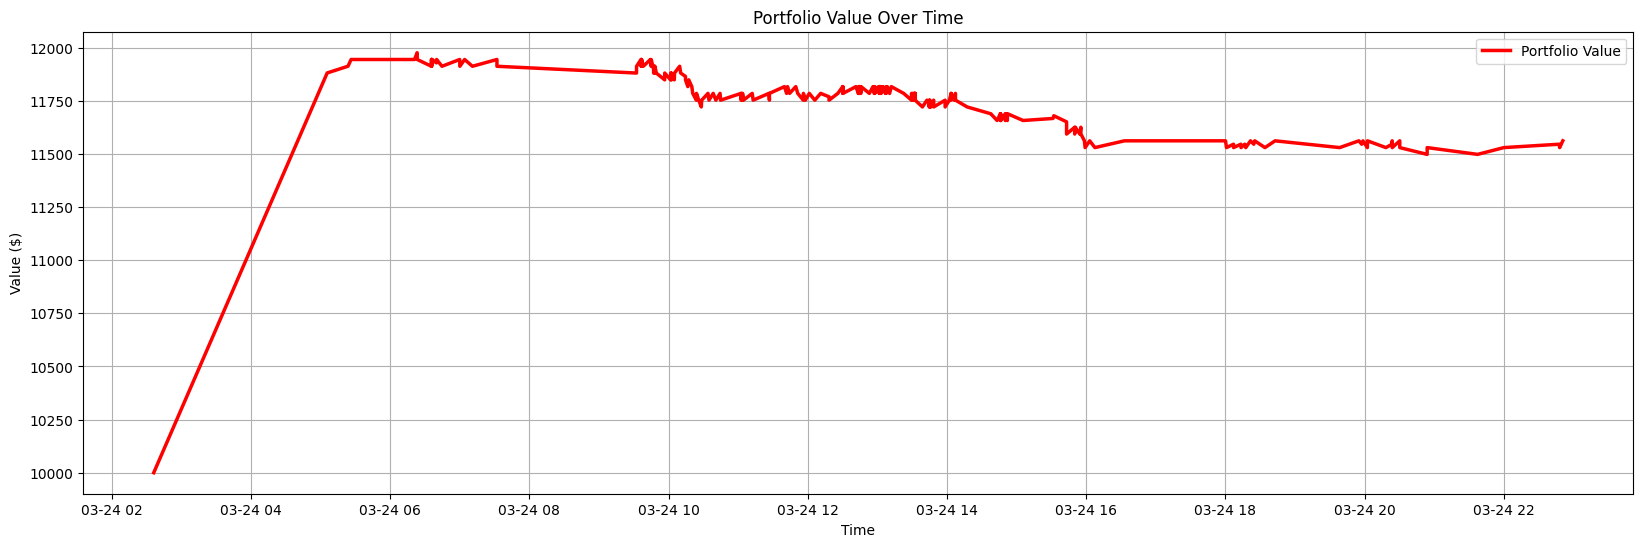

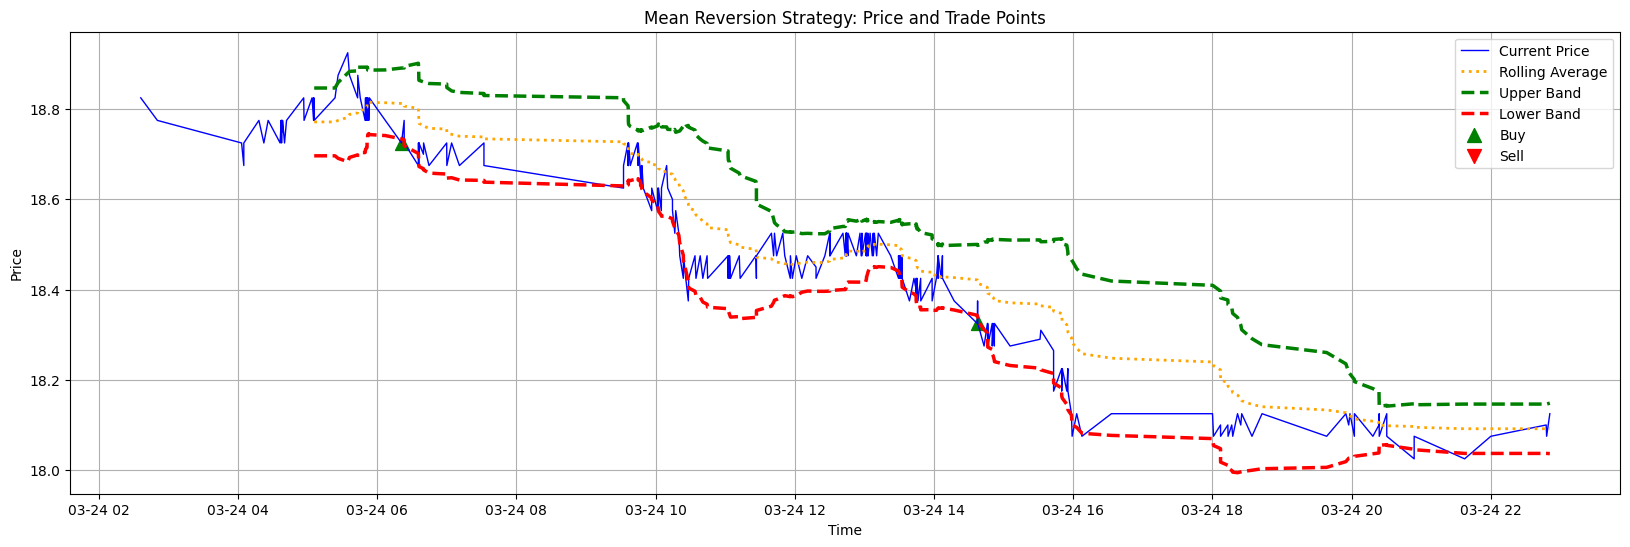

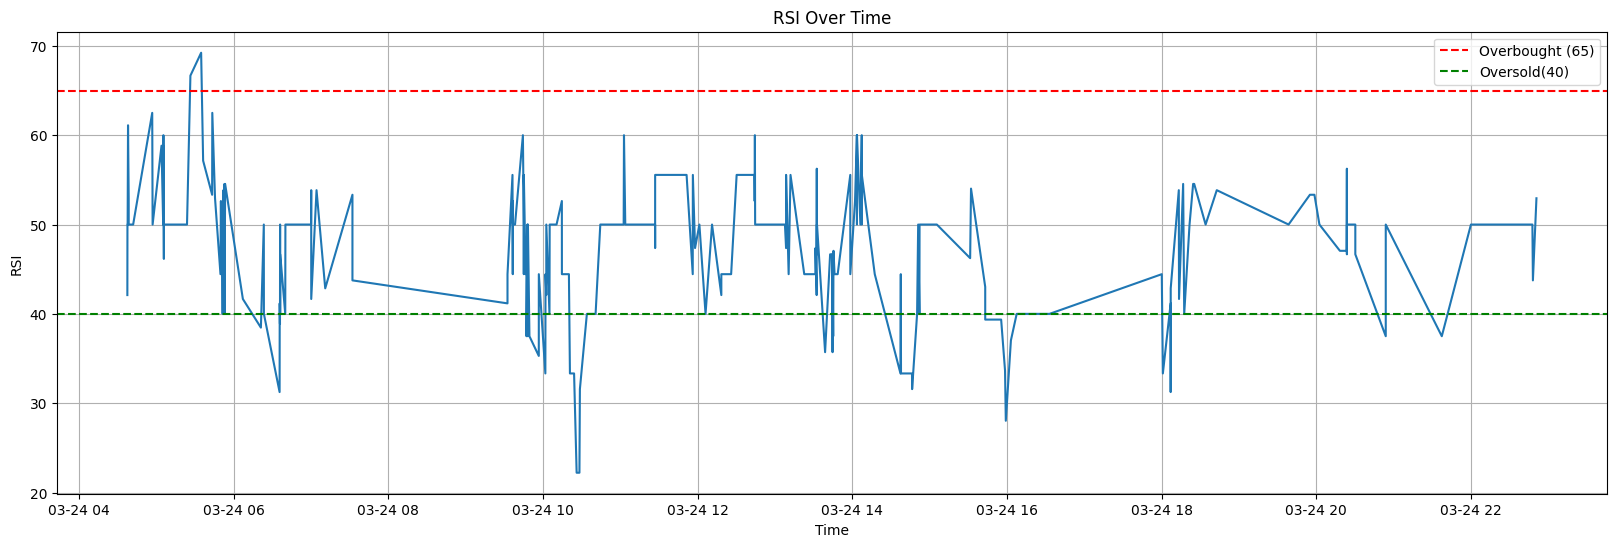

In [19]:
portfolio_dataframe = best_result[0]
bollinger_rsi_strategy_plot3(portfolio_dataframe)
bollinger_rsi_strategy_plot1(data, best_result[1])
bollinger_rsi_strategy_plot2(data, rsi_overbought_limit, rsi_oversold_limit)

## Parameter Tuning & Strategy Visualization

In [20]:
# !pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output

# UI controls
rolling_slider = widgets.IntSlider(value=30, min=5, max=50, step=1, description='Rolling:')
rsi_slider = widgets.IntSlider(value=10, min=2, max=30, step=1, description='RSI Window:')
sl_slider = widgets.FloatSlider(value=0.02, min=0.0, max=0.1, step=0.01, description='Stop Loss:')
tp_slider = widgets.FloatSlider(value=0.03, min=0.0, max=0.1, step=0.01, description='Take Profit:')
rsi_low_slider = widgets.IntSlider(value=40, min=0, max=50, description='RSI Low:')
rsi_high_slider = widgets.IntSlider(value=65, min=50, max=100, description='RSI High:')
capital_input = widgets.IntText(value=10000, description='Capital:')

run_button = widgets.Button(description="Run Backtest", button_style='success')

ui = widgets.VBox([
    rolling_slider,
    rsi_slider,
    sl_slider,
    tp_slider,
    rsi_low_slider,
    rsi_high_slider,
    capital_input,
    run_button
])

output = widgets.Output()

def on_run_clicked(b):
    with output:
        clear_output(wait=True)
        window = rolling_slider.value
        rsi_window = rsi_slider.value
        sl = sl_slider.value
        tp = tp_slider.value
        rsi_low = rsi_low_slider.value
        rsi_high = rsi_high_slider.value
        capital = capital_input.value

        # Recalculate indicators
        data['Mean'] = (data['Ask'] + data['Bid']) / 2
        data['Rolling Avg'] = data['Mean'].rolling(window=window).mean()
        data['Rolling STD'] = data['Mean'].rolling(window=window).std()
        data['Upper Band'] = data['Rolling Avg'] + 2 * data['Rolling STD']
        data['Lower Band'] = data['Rolling Avg'] - 2 * data['Rolling STD']
        data['RSI'] = rsi(rsi_window, data)

        # Run strategy
        portfolio_df, trades, final_val, ret_pct = bollinger_rsi_strategy(
            sl, tp, rsi_low, rsi_high, data
        )

        # Results
        print(f"📌 Rolling Window: {window}")
        print(f"📈 Final Portfolio: ${final_val:.2f} | Return: {ret_pct:.2f}%")
        print(f"🛒 Trades: {len(trades)}")
        display(pd.DataFrame(trades))

        # Plots
        bollinger_rsi_strategy_plot3(portfolio_df)
        bollinger_rsi_strategy_plot1(data, trades)
        bollinger_rsi_strategy_plot2(data, rsi_high, rsi_low)

run_button.on_click(on_run_clicked)

display(ui, output)


Output()